# CS5489 - Machine Learning
# Lecture 11a - Auto-Encoders and Deep Generative Models
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Unsupervised models
  - Autoencoders
  - Denoising Autoencoders
- Deep generative models
  - Variational Autoencoders
  - GANs

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    MaxPooling2D, UpSampling2D, Lambda, Reshape, GlobalAveragePooling2D, \
                                    Concatenate, GlobalMaxPooling2D, GaussianNoise
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

2.4.0 2.4.1


In [3]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [5]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

In [6]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


In [7]:
# Reshape the images to a vector
# and map the data to [0,1]
trainXraw = trainimg.reshape((len(trainimg), -1), order='C') / 255.0
testXraw = testimg.reshape((len(testimg), -1), order='C') / 255.0

# center the image data (but don't change variance)
scaler = preprocessing.StandardScaler(with_std=False)
trainX = scaler.fit_transform(trainXraw)
testX  = scaler.transform(testXraw)

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)

print(trainX.shape)
print(trainYb.shape)

(6000, 784)
(6000, 10)


In [8]:
# generate a fixed validation set using 10% of the training set
vtrainX, validX, vtrainYb, validYb = \
  model_selection.train_test_split(trainX, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

# validation data
validset  = (validX, validYb)

In [9]:
# scale to 0-1
trainI = (trainimg.reshape((6000,28,28,1)) / 255.0)
testI  = (testimg.reshape((10000,28,28,1)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 28, 28, 1)
(10000, 28, 28, 1)


In [10]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Neural Networks and Unsupervised Learning
- How to use NN for dimensionality reduction or clustering?


# Autoencoder
- learn a latent respresentation of teh data.
- Use the hidden layer as the lower-dimensional representation ("code", "bottleneck" layer)
- Train the network to "encode" and "decode"
  - run it through the encoding-decoding network
  - minimize the difference between the output and the original input
<center><img src="imgs/ae.png" width=400></center>

# Autoencoder
- encode and decode with NN:
  - encoder: $\mathbf{z} = f(\mathbf{x})$
  - decoder: $\hat{\mathbf{x}} = g(\mathbf{z})$
- reconstruction: $\hat{\mathbf{x}} = g( f(\mathbf{x}))$
- Goal: minimize the reconstruction loss.
  - MSE (real inputs): $||\mathbf{x}-\hat{\mathbf{x}}||^2$
  - binary cross-entropy (inputs bounded in [0,1]): $\mathbf{x} \log \hat{\mathbf{x}} + (1-\mathbf{x})\log(1-\hat{\mathbf{x}})$

# Weight Sharing
- to reduce the number of parameters, share weights between the two layers
- D's weights are the transpose of E's weights
  - encoder: $\mathbf{z} = f(\mathbf{x}) = h_1(\mathbf{A}^T\mathbf{x})$
  - decoder: $\hat{\mathbf{x}} =  g(\mathbf{z}) = h_2(\mathbf{A}\mathbf{z})$
- if $h_1$ and $h_2$ are linear activations, then it's similar to PCA.
  - except the orthogonal constraint on $\mathbf{A}$
- use more layers/non-linearities gives more general latent representations.

# Example on MNIST
- Reshape the images into vectors, and scale to [0,1]

In [11]:
# Reshape the images and map the data to [0,1]
trainXraw = trainimg.reshape((len(trainimg), -1), order='C') / 255.0
testXraw = testimg.reshape((len(testimg), -1), order='C') / 255.0

In [12]:
# generate a fixed validation set using 10% of the training set
vtrainXraw, validXraw = \
  model_selection.train_test_split(trainXraw, 
  train_size=0.9, test_size=0.1, random_state=4487)

- Define the Dense layer using transposed weights from another layer.
  - has its own bias term

In [13]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dense.input_shape[-1])

- Use `Model` class to define encoder, decoder, and the combination

In [14]:
K.clear_session()
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# Build the Encoder model
input_img = Input(shape=(784,))                                  # input layer
encoder_dense_1 = Dense(10, activation='relu', name="encoder_1") # create dense layer
encoded = encoder_dense_1(input_img)                             # connect input
encoder = Model(input_img, encoded, name="encoder")              # create model

# Build the Decoder model
encoded_input = Input(shape=(10,))
decoder_dense_1 = DenseTranspose(encoder_dense_1, activation='sigmoid', name="decoder_1")
decoded = decoder_dense_1(encoded_input)
decoder = Model(encoded_input, decoded, name="decoder")

# build the full autoencoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))

- Encoder and decoder subnetworks

In [15]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder_1 (Dense)            (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [16]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
decoder_1 (DenseTranspose)   (None, 784)               8634      
Total params: 8,634
Trainable params: 8,634
Non-trainable params: 0
_________________________________________________________________


- Full auto-encoder network
  - Composed of the encoder and decoder models

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 10)                7850      
_________________________________________________________________
decoder (Functional)         (None, 784)               8634      
Total params: 8,634
Trainable params: 8,634
Non-trainable params: 0
_________________________________________________________________


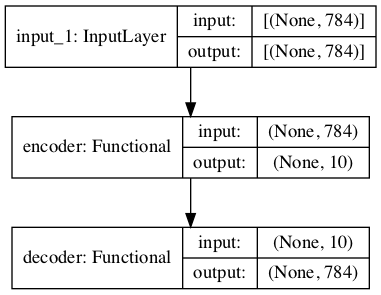

In [18]:
# visualize the network
tf.keras.utils.plot_model(autoencoder, to_file='tmp_model.png', show_shapes=True)

- compile the model
  - outputs are in [0,1], so use cross-entropy

In [19]:
 # early stopping criteria
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0.0001, patience=10,
                            verbose=1, mode='auto')
                
# compile and fit the network
autoencoder.compile(loss=keras.losses.binary_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True))

- fit the model
  - the target is the same as the input

In [20]:
# fit the model: the input and output are the same
# write to a log directory to see training process
history = autoencoder.fit(vtrainXraw, vtrainXraw, 
                 epochs=20, batch_size=50, 
                 callbacks=[earlystop],
                 validation_data=(validXraw, validXraw), verbose=False)

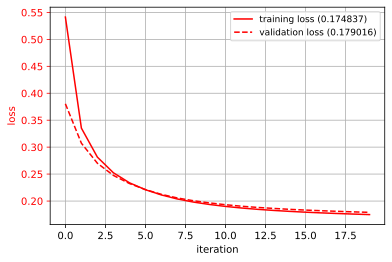

In [21]:
plot_history(history)

- Visualize the weights of the hidden layer in E
  - each hidden node activates on a particular structure

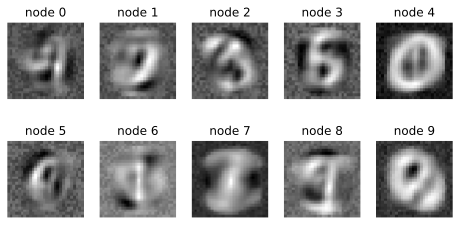

In [22]:
W = encoder.get_layer(index=1).get_weights()[0]
filter_list = [W[:,i].reshape((28,28)) for i in range(W.shape[1])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="node %d")

- Encode images into low-dim representation.

In [23]:
Z = encoder.predict(trainXraw)
Z.shape

(6000, 10)

In [24]:
Wlist = []
for ii in [210,4,101,9,294]:
    d = metrics.pairwise.euclidean_distances(Z, [Z[ii]])
    inds = argsort(d.ravel())
    for x in inds[0:10]:
        Wlist.append(trainXraw[x].reshape((28,28)))
        
Zfig = plt.figure()
tmp = [1,0,0,0,0,0,0,0,0,0]*5
tmp2 = [0]*50
show_imgs(Wlist, nc=10, highlight_red=tmp, highlight_green=tmp2)
plt.close()

- for the given highlighted red digit
  - show the 9 nearest neighbors in the latent space

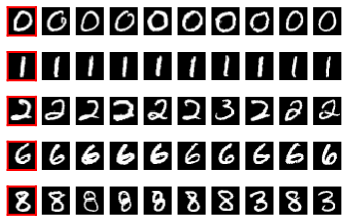

In [25]:
Zfig

In [26]:
def plot_embedding(X, Y, perplexity):
    IPython.core.display.set_matplotlib_formats("retina") # switch to png since the next figure is complex
    tsne = manifold.TSNE(n_components=2, init='pca', perplexity=perplexity, random_state=11)
    x_pts = tsne.fit_transform(X)
    fig = plt.figure(figsize=(8,8))
    plt.scatter(x_pts[:, 0], x_pts[:, 1], c=Y, s=2, cmap=plt.get_cmap('jet'))
    plt.grid()
    plt.show()
    plt.close()
    IPython.core.display.set_matplotlib_formats("svg")

- Visualize a t-SNE embedding of the latent-space

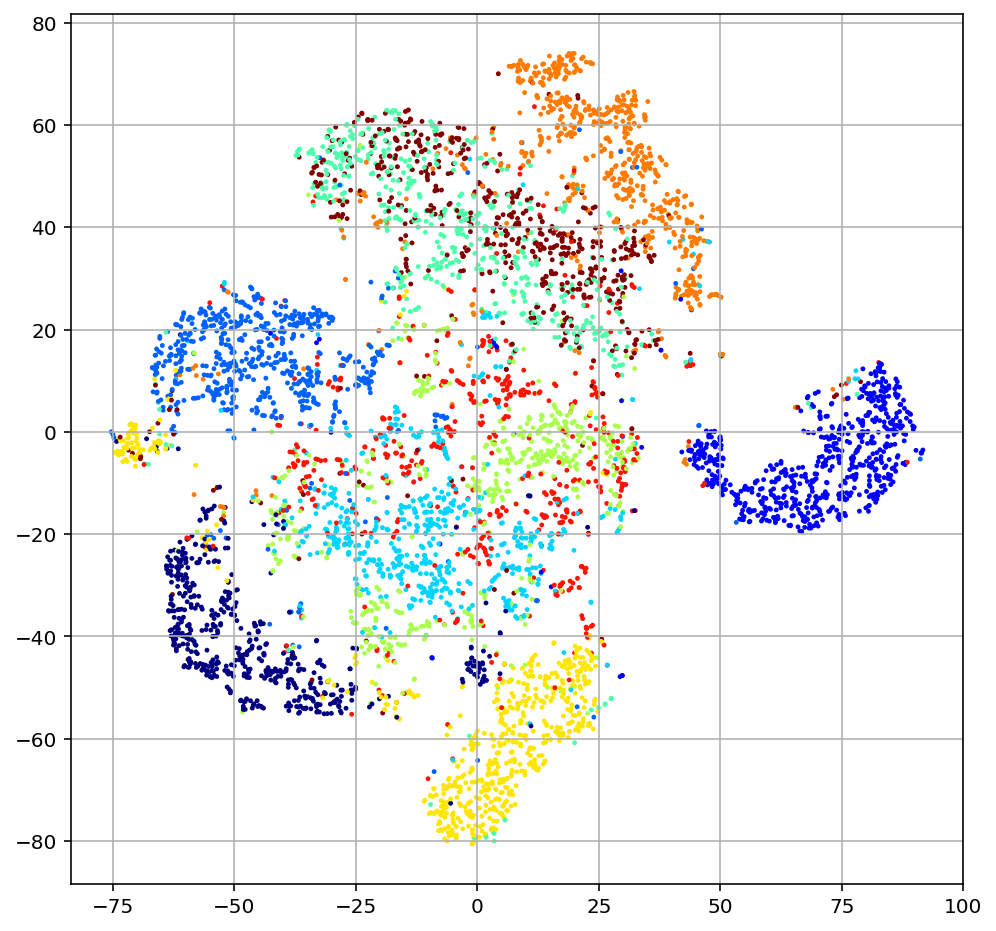

In [27]:
plot_embedding(Z, trainY, perplexity=30.)

- Visualize the reconstruction of the input image

In [28]:
testXrecon = decoder.predict(encoder.predict(testXraw))

In [29]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testXraw[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()

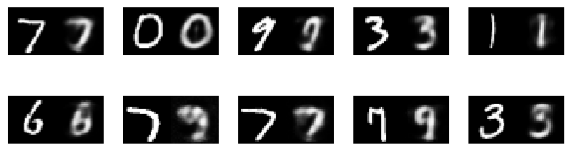

In [30]:
rfig

# Better Representations
- How to encourage better representations in the latent space?
- Two approaches:
  1. Regularize the latent space
    - e.g., using a sparisty-inducing regularizer of the latent vector
    - $L = ||\mathbf{x}-g(f(\mathbf{x}))||^2 + \lambda ||f(\mathbf{x})||_1$
  2. Denoising auto-encoder (DAE)
    - add noise to make the encoder learn more about the data manifold.

# Denoising Autoencoder
- **Idea**: the AE's goal is to minimize $||\mathbf{x}-g(f(\mathbf{x}))||^2$. 
  - the minimum occurs when $g(f(\mathbf{x}))=\mathbf{x}$, i.e., the identity function.
- **Problem**: The network can obtain this arbitrariliy if enough capacity.
  - but without learning anything about the data distribution.

- **Solution**: 
  - Force the AE to learn more about the data by corrupting the inputs.
    - minimize $||\mathbf{x}-g(f(\tilde{\mathbf{x}}))||^2$
    - $\tilde{\mathbf{x}}$ is a corrupted input
      - e.g., adding Gaussian noise, or zeroing some values
  - AE will learn how to "undo" the corruption, which requires learning the structure of the data manifold.
    - allows "code" size to be larger than the input size

# DAE Interpretation (1)
- DAE is learning a vector field from the corrupted $\tilde{\mathbf{x}}$ to the clean $\mathbf{x}$ (the data manifold).

<center><img src="imgs/dae-vf.jpg" width=600></center>

# Example

<center><img src="imgs/dae-vf-eg.png" width=600></center>

# Denoising Autoencoder
- randomly corrupt the input (by setting values to 0)
- implemented by applying Dropout on the inputs.
<center><img src="imgs/dae.png" width=600></center>

In [31]:
K.clear_session()
# initialize random seed
random.seed(4487); tf.random.set_seed(4487)

# Build the Encoder model
input_img = Input(shape=(784,))
corrupted_img = Dropout(rate=0.3)(input_img)
encoded = Dense(10, activation='relu')(corrupted_img)
encoder = Model(input_img, encoded, name='DAE-encoder')

# Build the Decoder model (here we don't share weights)
encoded_input = Input(shape=(10,))
decoded = Dense(784, activation='sigmoid')(encoded_input)
decoder = Model(encoded_input, decoded, name='DAE-decoder')

# build the full autoencoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))

- Encoder and decoder subnetworks

In [32]:
encoder.summary()

Model: "DAE-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [33]:
decoder.summary()

Model: "DAE-decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               8624      
Total params: 8,624
Trainable params: 8,624
Non-trainable params: 0
_________________________________________________________________


- Full auto-encoder network
  - Composed of the encoder and decoder models

In [34]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
DAE-encoder (Functional)     (None, 10)                7850      
_________________________________________________________________
DAE-decoder (Functional)     (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


- Compile the model

In [35]:
# compile and fit the network
autoencoder.compile(loss=keras.losses.binary_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True))

- Fit the model

In [36]:
# fit the model: the input and output are the same
history = autoencoder.fit(vtrainXraw, vtrainXraw, 
                 epochs=20, batch_size=50, 
                 callbacks=[earlystop],
                 validation_data=(validXraw, validXraw), verbose=False)

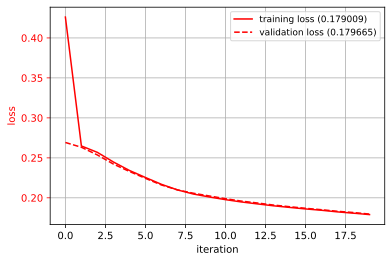

In [37]:
plot_history(history)

- Encode images into low-dim representation.

In [38]:
Z = encoder.predict(trainXraw)
Z.shape

(6000, 10)

- Visualize the nearby neighbors in the low-dim representation.
  - each row represents one set of neighbors

In [39]:
Wlist = []
for ii in [210,4,101,9,294]:
    d = metrics.pairwise.euclidean_distances(Z, [Z[ii]])
    inds = argsort(d.ravel())
    for x in inds[0:10]:
        Wlist.append(trainXraw[x].reshape((28,28)))
        
tmp = [1,0,0,0,0,0,0,0,0,0]*5
tmp2 = [0]*50
Zfig = plt.figure()
show_imgs(Wlist, nc=10, highlight_red=tmp, highlight_green=tmp2)
plt.close()

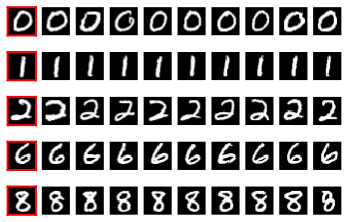

In [40]:
Zfig

- Visualize the weights of the hidden layer that generate codes
  - each hidden node activates on a particular structure

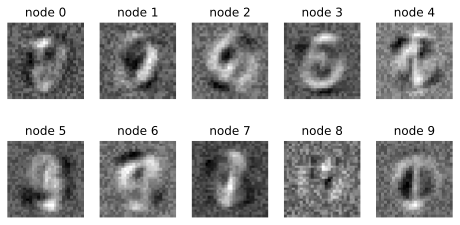

In [41]:
W = encoder.get_layer(index=2).get_weights()[0]
filter_list = [W[:,i].reshape((28,28)) for i in range(W.shape[1])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="node %d")

- Visualize the weights that project the code into an image
  - the image structures match those of the encoder, but are smoother.

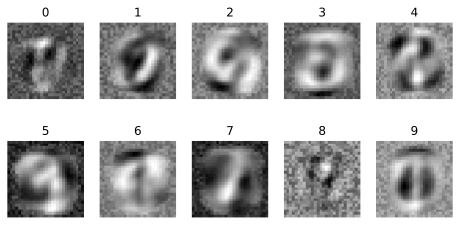

In [42]:
W = decoder.get_layer(index=1).get_weights()[0]
filter_list = [W[i,:].reshape((28,28)) for i in range(W.shape[0])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="%d")

- Visualize the reconstruction of the input image

In [43]:
testXrecon = decoder.predict(encoder.predict(testXraw))

In [44]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testXraw[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()


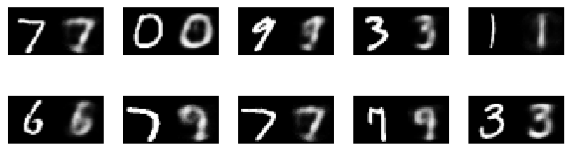

In [45]:
rfig

- Corrupt the input image and encode-decode
  - performs "denoising" of the input

In [46]:
noisytest = testXraw * random.binomial(n=1,p=1-0.3,size=testXraw.shape)
testXrecon = decoder.predict(encoder.predict(noisytest))

In [47]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (noisytest[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
dfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()

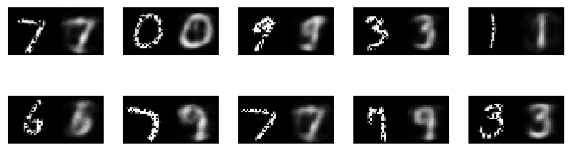

In [48]:
dfig

# DAE Interpretation 2
- Learning a reconstruction distribution $p_{\mathrm{recon}}(\mathbf{x}|\tilde{\mathbf{x}})$
- Generative process:
  1. sample training example $\mathbf{x}$
  2. corrupt $\tilde{\mathbf{x}} \sim C(\tilde{\mathbf{x}}|\mathbf{x})$
  3. use $(\tilde{\mathbf{x}},\mathbf{x})$ as a training example to estimate
  $$\begin{aligned}p_{\mathrm{recon}}(\mathbf{x}|\tilde{\mathbf{x}}) &= p_{\mathrm{decoder}}(\mathbf{x}|\mathbf{z}), \\ \mathbf{z} &= f(\tilde{\mathbf{x}})\end{aligned}$$

- Assume $p_{\mathrm{decoder}}(\mathbf{x}|\mathbf{z})$ is Gaussian:
  - Note that $\log p_{\mathrm{decoder}}(\mathbf{x}|\mathbf{z}) = -||\mathbf{x}-g(\mathbf{z})||^2$ (negative MSE loss)
- Minimize the loss over the training distribution
  - $\sum_i ||\mathbf{x}_i - g(f(\tilde{\mathbf{x}}_i))||^2$
- is equivalent to maximizing the expected log probability
$$\mathbb{E}_{\mathbf{x}\sim p_{\mathrm{data}}(\mathbf{x})} \mathbb{E}_{\tilde{\mathbf{x}}\sim C(\tilde{\mathbf{x}}|\mathbf{x})} [\log p_{\mathrm{decoder}}(\mathbf{x}|\mathbf{z}=f(\tilde{\mathbf{x}}))]$$
  - expectation is over the data and the corruption.

# Convolutional Auto-Encoder
- Encoder - a standard CNN (w/o classifier)
  - Extract a feature map

In [49]:
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# the Conv2D encoder
input_img2 = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded2 = MaxPooling2D((2, 2), padding='same')(x)
encoder2 = Model(input_img2, encoded2, name='ConvEncoder')
# the representation is (4, 4, 8) i.e. 128-dimensional

- Decoder
  - the opposite architecture
  - Replace maxpooling with upsampling 

In [50]:
# the Conv2D decoder
encoded_input2 = Input(shape=(4,4,8))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder2 = Model(encoded_input2, decoded2, name='ConvDecoder')

- Connect the two to form the autoencoder

In [51]:
# connect the encoder to the decoder
autoencoder2 = Model(input_img2, decoder2(encoder2(input_img2)))
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

- Encoder and Decoders

In [52]:
encoder2.summary()

Model: "ConvEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           

In [53]:
decoder2.summary()

Model: "ConvDecoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 4, 8)]         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 16)        

- The whole autoencoder

In [54]:
autoencoder2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
ConvEncoder (Functional)     (None, 4, 4, 8)           1904      
_________________________________________________________________
ConvDecoder (Functional)     (None, 28, 28, 1)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


- Now fit the model

In [55]:
# training with images
history = autoencoder2.fit(vtrainI, vtrainI,
                            epochs=50,
                            batch_size=128,
                            shuffle=True,
                            callbacks=[earlystop, TensorBoard(log_dir='./logs/ae2')],
                            validation_data=(validI, validI), verbose=False)

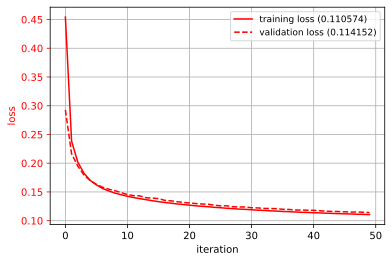

In [56]:
plot_history(history)

- Visualize the latent space

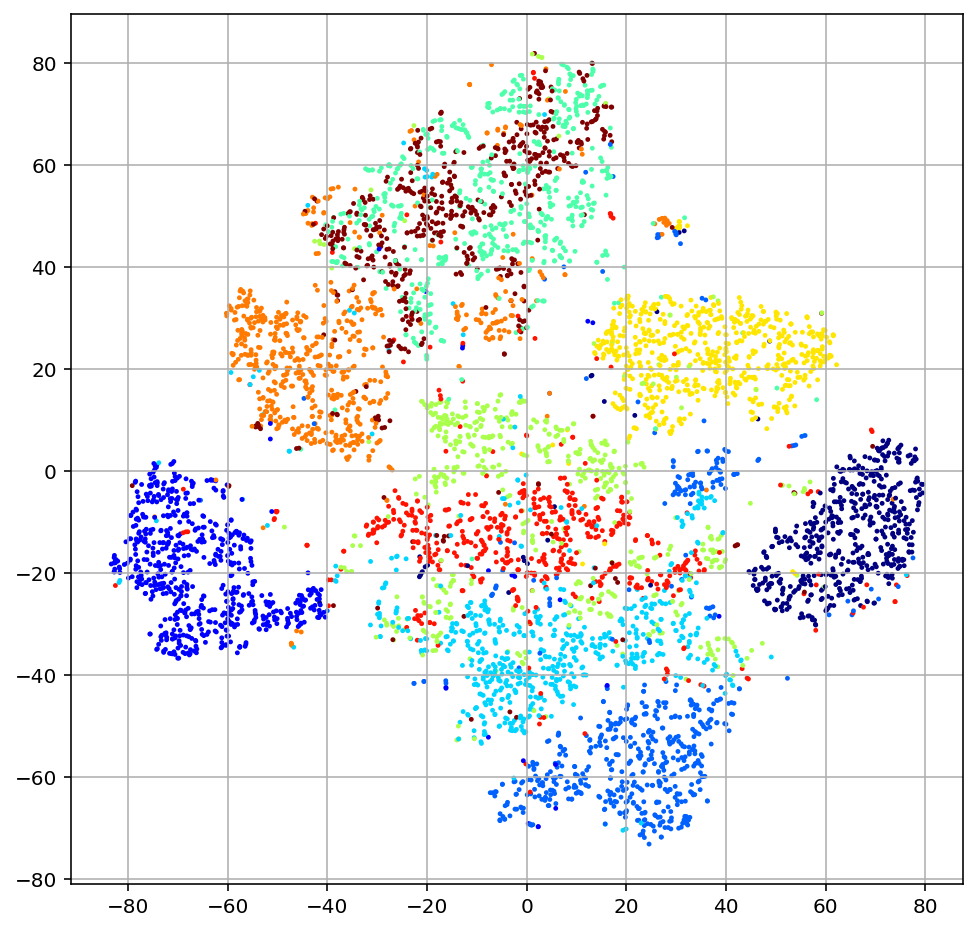

In [57]:
Z = encoder2.predict(trainI)
plot_embedding(Z.reshape((Z.shape[0],-1)), trainY, perplexity=30.)

- Encode and reconstruct an image

In [58]:
testIrecon = decoder2.predict(encoder2.predict(testI))

- Better visualization

In [59]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testI[i].reshape((28,28)), testIrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()

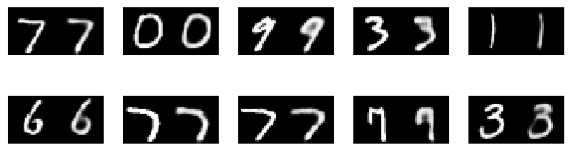

In [60]:
rfig

- Traverse the latent space
  - Sample points: $$\mathbf{z}_1 = f(\mathbf{x}_1), \mathbf{z}_2 = f(\mathbf{x}_2)$$
  - interpolate: $$\mathbf{\hat{z}} = (1-\alpha) \mathbf{z}_1 + \alpha \mathbf{z}_2, 0\leq \alpha\leq 1$$
  - reconstruct: $$\mathbf{\hat{x}} = g(\mathbf{\hat{z}})$$
- Change a 7 into a 1

In [61]:
def Xinterp(X,sp=10):
    alpha = linspace(0,1,sp).reshape((sp,)+(ndim(X)-1)*(1,))
    Xint = X[0,:]*(1-alpha) + X[1,:]*alpha
    return Xint

In [62]:
inds = [0,40]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp(X))

In [63]:
rfig = plt.figure(figsize=(10,3))
show_imgs(Xd.reshape((10,28,28)),nc=10)
plt.close()

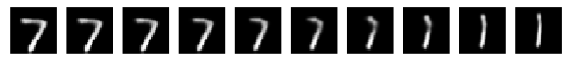

In [64]:
rfig

- Traverse the latent space between a 7, 1, 9, and 4
  - captures shapes in between

In [65]:
def Xinterp2(X, sp=10):
    # [TL, TR, BL, BR]
    
    Xtbl = Xinterp(X[[0,2],:], sp=sp)
    Xtbr = Xinterp(X[[1,3],:], sp=sp)
    
    # interpolate inbetween    
    Xall = zeros((sp*sp,) + Xtbl.shape[1:])
    
    tmps = array(Xtbl.shape)
    tmps[0] = 1
    for i in range(sp):
        tmpX = concatenate((Xtbl[i,:].reshape(tmps), Xtbr[i,:].reshape(tmps)), axis=0)
        Xall[sp*i:sp*(i+1),:] = Xinterp(tmpX, sp=sp)
    return Xall

In [66]:
inds = [0, 40, 20, 6]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp2(X, sp=8))
rfig = plt.figure(figsize=(6,6))
show_imgs(Xd.reshape((64,28,28)),nc=8)
plt.close()

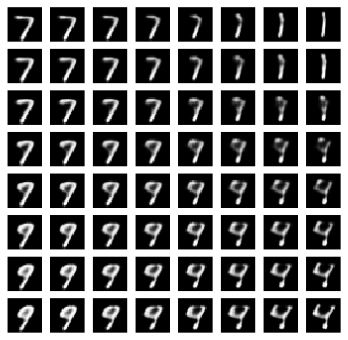

In [67]:
rfig

- Traverse the latent space between different 7s
  - captures different shapes of 7

In [68]:
mydigits = where(testY==7)[0]
inds = mydigits[10:14]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp2(X,sp=8))
rfig = plt.figure(figsize=(6,6))
show_imgs(Xd.reshape((64,28,28)),nc=8)
plt.close()

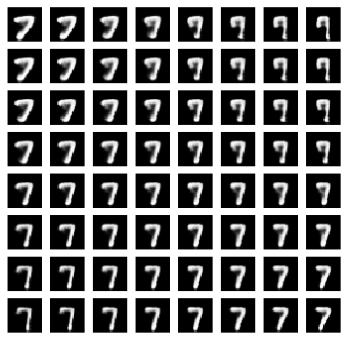

In [69]:
rfig

# Semantic Segmentation
- Label each pixel in the image with a category label.

<img src="imgs/semseg.png" width=600>

# Fully-convolutional network (FCN)
- learns mapping from input image to output segmentation
  - encoder/decoder structure similar to AE.
  - middle contains the low-dim representation.

<img src="imgs/fcn.png" width=800>

# U-net: More sophisticated FCN
- Idea: concatenate higher-resolution features when upsampling
  - Better localize boundaries.
  - Mix high-level and low-level features.
<img src="imgs/unet.png" width=600>
